<a href="https://colab.research.google.com/github/dattatreyuluakella17/gloves_detection/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="EHMtAg3pjbgvd7xaKTF5")
project = rf.workspace("glove-uylxg").project("glove-q7czq")
version = project.version(1)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 50.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to glove-1 in yolov8:: 100%|██████████| 3428/3428 [00:00<00:00, 7743.70it/s]


In [4]:

import random
import shutil
from pathlib import Path

SOURCE_DIR = "/content/glove-1"
DEST_DIR = "/content/glove-merged"

TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1
SEED = 42

random.seed(SEED)

# Create destination folders
for split in ["train", "val", "test"]:
    (Path(DEST_DIR) / "images" / split).mkdir(parents=True, exist_ok=True)
    (Path(DEST_DIR) / "labels" / split).mkdir(parents=True, exist_ok=True)

image_files = []

# IMPORTANT: folder structure is split/images/*.png
for split in ["train", "valid", "test"]:
    img_dir = Path(SOURCE_DIR) / split / "images"
    label_dir = Path(SOURCE_DIR) / split / "labels"

    if not img_dir.exists():
        print(f" Missing: {img_dir}")
        continue

    imgs = list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.png"))
    print(f"{split}: {len(imgs)} images")

    for img in imgs:
        image_files.append((img, label_dir / f"{img.stem}.txt"))

print(f"\nTotal images found: {len(image_files)}")

if not image_files:
    raise RuntimeError("No images found — check structure.")

random.shuffle(image_files)

total = len(image_files)
train_end = int(total * TRAIN_RATIO)
val_end = train_end + int(total * VAL_RATIO)

splits = {
    "train": image_files[:train_end],
    "val": image_files[train_end:val_end],
    "test": image_files[val_end:]
}

for split, files in splits.items():
    for img_path, label_path in files:
        if not label_path.exists():
            print(f" Missing label: {img_path.name}")
            continue

        shutil.copy(img_path, Path(DEST_DIR) / "images" / split / img_path.name)
        shutil.copy(label_path, Path(DEST_DIR) / "labels" / split / label_path.name)

print("\n✅ Dataset merged and re-split successfully")
for k, v in splits.items():
    print(f"{k}: {len(v)}")


train: 1462 images
valid: 138 images
test: 108 images

Total images found: 1708

✅ Dataset merged and re-split successfully
train: 1195
val: 341
test: 172


In [5]:
import cv2
import random
from pathlib import Path


In [6]:
class_map = {
    0: 'glove',
    1: 'no_glove'
}

In [7]:
import matplotlib.pyplot as plt

def visualize_image(image_path, label_path):
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w, _ = image.shape

    with open(label_path, "r") as f:
        lines = f.readlines()

    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    for line in lines:
        cls, xc, yc, bw, bh = map(float, line.split())

        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)

        label = class_map[int(cls)]

        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                          fill=False, edgecolor='lime', linewidth=2)
        )
        plt.text(x1, y1 - 5, label, color='lime', fontsize=10)

    plt.axis("off")
    plt.show()


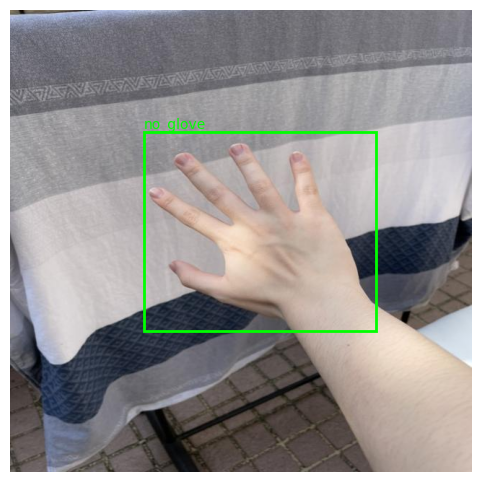

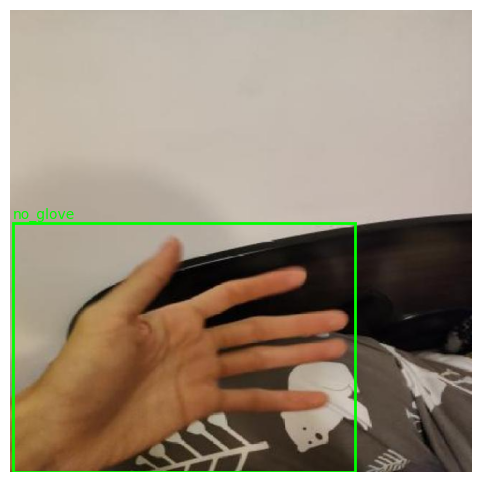

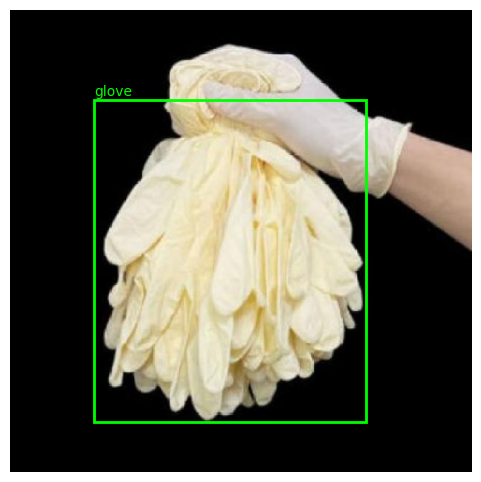

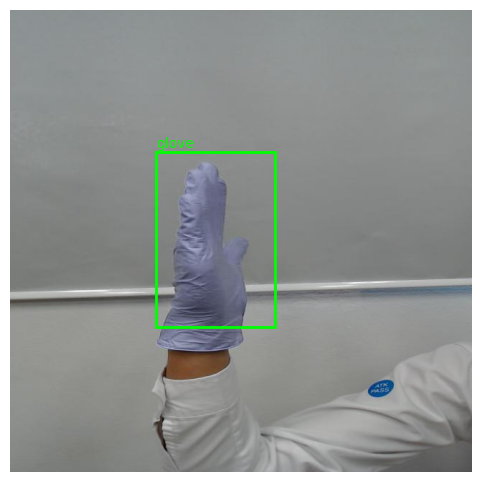

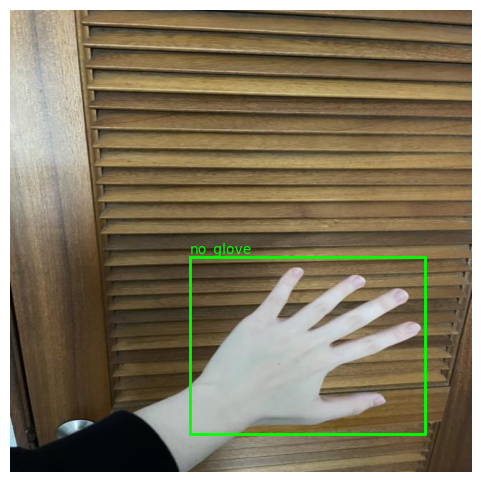

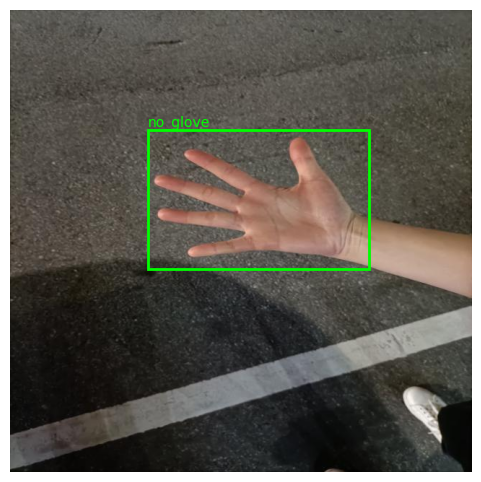

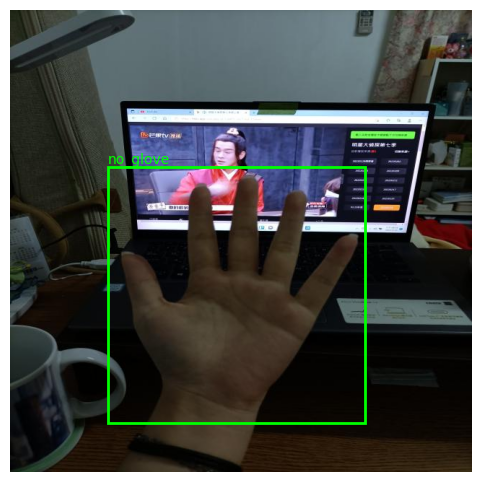

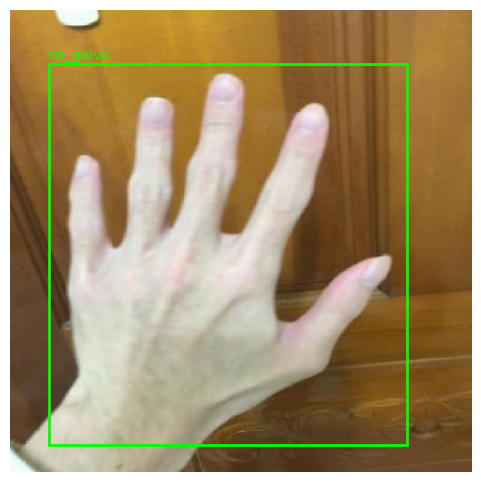

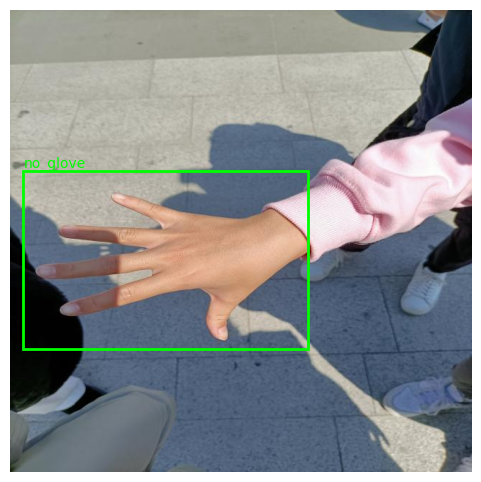

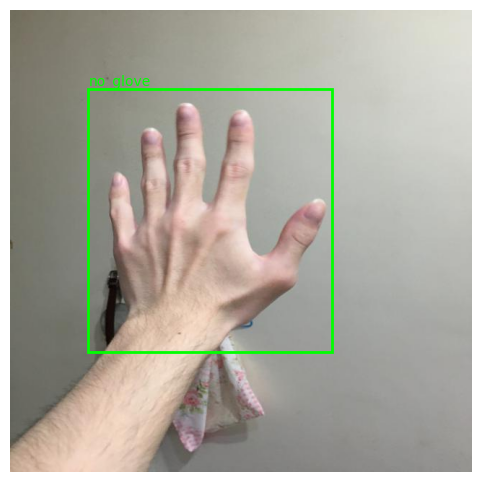

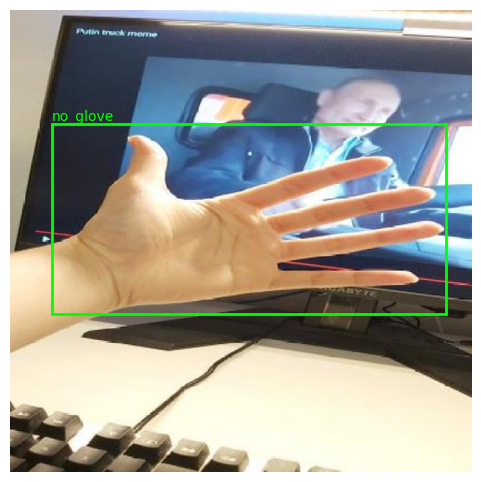

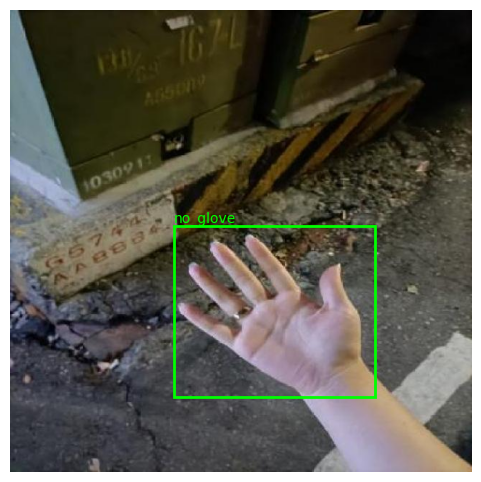

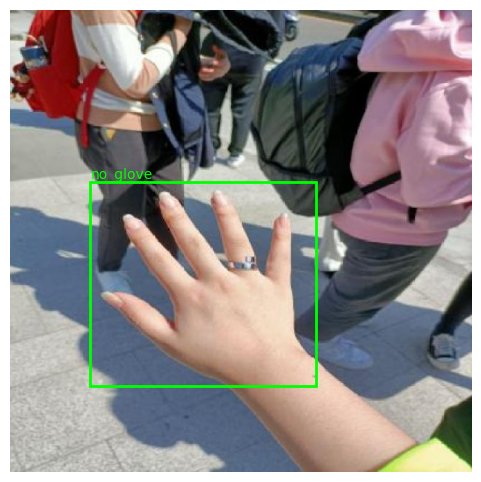

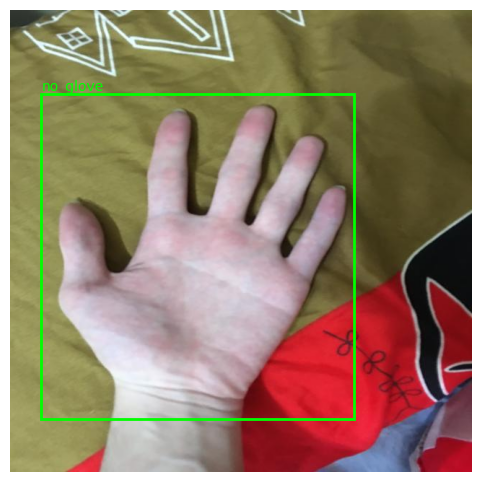

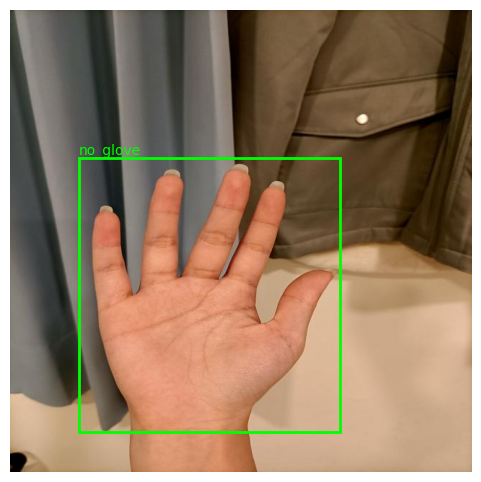

In [8]:
from pathlib import Path
import random

base = Path('/content/glove-merged')
split = "train"

image_dir = base / "images" / split
label_dir = base / "labels" / split

all_images = list(image_dir.glob("*.jpg"))
samples = random.sample(all_images, min(15, len(all_images)))

for img_path in samples:
    lbl_path = label_dir / f"{img_path.stem}.txt"
    visualize_image(img_path, lbl_path)


In [9]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.4 MB/s eta 0:00:00


In [11]:
from ultralytics import YOLO
from pathlib import Path

# ---------------- PATHS ----------------
BASE_DIR = Path('/content/glove-merged')
DATA_YAML = BASE_DIR / "data.yaml"

PROJECT_DIR = Path("/content/glove-merged/yolo_runs")
PROJECT_DIR.mkdir(parents=True, exist_ok=True)

RUN_NAME = "glove_detection"

# ---------------- MODEL ----------------
model = YOLO("yolov8n.pt")

# ---------------- TRAIN ----------------
train_results = model.train(
    data=str(DATA_YAML),
    epochs=50,
    imgsz=640,
    batch=16,
    device=0,
    workers=4,
    project=str(PROJECT_DIR),
    name=RUN_NAME,
    pretrained=True
)

# ---------------- VALIDATION ----------------
val_results = model.val(
    model=str(PROJECT_DIR / RUN_NAME / "weights" / "best.pt"),
    data=str(DATA_YAML)
)

# ---------------- TEST ----------------
TEST_IMAGES = BASE_DIR / "images" / "test"

predict_results = model.predict(
    model=str(PROJECT_DIR / RUN_NAME / "weights" / "best.pt"),
    source=str(TEST_IMAGES),
    conf=0.15,
    save=True,
    project=str(PROJECT_DIR),
    name=f"{RUN_NAME}_test"
)

print("Training, validation, and testing completed successfully.")


Ultralytics 8.4.0 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/glove-merged/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=glove_detection2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

In [13]:
from ultralytics import YOLO
from pathlib import Path
import json
import cv2

# ---------------- PATHS ----------------
BASE_DIR = Path('/content/glove-merged')
MODEL_PATH = BASE_DIR / "yolo_runs/glove_detection2/weights/best.pt"

IMAGE_DIR = BASE_DIR / "images/test"
OUTPUT_DIR = BASE_DIR / "output"
LOG_DIR = BASE_DIR / "logs"

OUTPUT_DIR.mkdir(exist_ok=True)
LOG_DIR.mkdir(exist_ok=True)

# ---------------- LOAD MODEL ----------------
model = YOLO(str(MODEL_PATH))

# ---------------- RUN INFERENCE ----------------
results = model.predict(
    source=str(IMAGE_DIR),
    conf=0.15,
    save=False,          # we save manually
    device=0
)

# ---------------- PROCESS RESULTS ----------------
for result in results:
    image_path = Path(result.path)
    image = cv2.imread(str(image_path))

    detections = []

    if result.boxes is not None:
        for box in result.boxes:
            cls_id = int(box.cls[0])
            label = model.names[cls_id]
            conf = float(box.conf[0])

            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

            detections.append({
                "label": label,
                "confidence": round(conf, 2),
                "bbox": [x1, y1, x2, y2]
            })

            # Draw bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                image,
                f"{label} {conf:.2f}",
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 255, 0),
                2
            )

    # ---------------- SAVE IMAGE ----------------
    out_image_path = OUTPUT_DIR / image_path.name
    cv2.imwrite(str(out_image_path), image)

    # ---------------- SAVE JSON LOG ----------------
    log_data = {
        "filename": image_path.name,
        "detections": detections
    }

    log_path = LOG_DIR / f"{image_path.stem}.json"
    with open(log_path, "w") as f:
        json.dump(log_data, f, indent=2)

print("Inference complete. Annotated images and JSON logs saved.")


image 1/172 /content/glove-merged/images/test/1596467278324_jpg.rf.01423fbaebf14791d0c02081948dffdf.jpg: 640x640 1 glove, 8.0ms
image 2/172 /content/glove-merged/images/test/1596474142153_jpg.rf.11472cba513558e841a413654385b72e.jpg: 640x640 2 gloves, 7.2ms
image 3/172 /content/glove-merged/images/test/1596474202968_jpg.rf.a083c88207b783c3267d63265949b4b3.jpg: 640x640 1 glove, 7.2ms
image 4/172 /content/glove-merged/images/test/1596612534922_jpg.rf.f1e4e1fc83acf1df5a647b65627bb9e8.jpg: 640x640 1 glove, 7.2ms
image 5/172 /content/glove-merged/images/test/1596620808435_jpg.rf.bafd9b6667c4a761b33b6057ee029923.jpg: 640x640 1 glove, 7.2ms
image 6/172 /content/glove-merged/images/test/1596727274637_jpg.rf.80fb25e7c248460202c2c54b0bbf3c96.jpg: 640x640 1 glove, 7.2ms
image 7/172 /content/glove-merged/images/test/1597123891191_jpg.rf.4a112881a2ab8d831322d92c02f9d36e.jpg: 640x640 1 glove, 7.2ms
image 8/172 /content/glove-merged/images/test/1597157409403_jpg.rf.e238d657bf7c2b2872994a0fc285ff48.jp